# Notebook
Notebook for prototyping and experimenting. 

### New Simulation Config


In [ ]:

# beam_settings = load_beam_config(config["beam"])

# lenses = [load_lens_config(lc) for lc in config["lenses"]]
# stages = [load_sim_stage_config(sc) for sc in config["stages"]]

# options = generate_simulation_options(config, "log")
# parameters = generate_simulation_parameters(config)


# sim_config = SimulationConfig(
#     beam=beam_settings,
#     lenses=lenses,
#     stages=stages,
#     parameters=parameters,
#     options=options
# )


# print("SIM CONFIG:")
# pprint(sim_config.beam)
# print("-"*50)
# pprint(sim_config.lenses)
# print("-"*50)
# pprint(sim_config.stages)
# print("-"*50)
# pprint(sim_config.parameters)
# print("-"*50)
# pprint(sim_config.options)



### DASK Experiments


In [ ]:
import time
import dask


@dask.delayed
def inc(x):
    time.sleep(1)
    return x + 1

@dask.delayed
def add(x, y):
    time.sleep(1)
    return x + y

In [ ]:
%%time

a = inc(1)
b = inc(1)
c = add(a, b)
c.visualize("mydask.png")
# c.dask
# c = c.compute()


In [ ]:
import zarr

arr = zarr.ones(shape=(100, 10000, 10000))

import dask.array as da

darr = da.from_zarr(arr) * np.arange(arr.shape[1])

import matplotlib.pyplot as plt

plt.imshow(darr[0, :, :])
plt.show()

### Custom Config

Load a custom config from key (allows for sweeping configs)


In [ ]:
%load_ext autoreload
%autoreload 2
from lens_simulation import utils, validation, Simulation, SimulationRunner
from pprint import pprint

from lens_simulation.Lens import generate_lens
from lens_simulation.Medium import Medium

config = utils.load_config("config_minimum.yaml")
config["log_dir"] = "log"


sim_runner = SimulationRunner.SimulationRunner("config.yaml")
sim_runner.setup_simulation()

conf_1 = sim_runner.simulation_configurations[0]
for conf in sim_runner.simulation_configurations:

    pprint(conf)
    print("------------ AFTER -------------- ")
    sim = Simulation.Simulation(conf)


### Mega Stack
Stack multiple simulations together for synchronised visualisation


In [156]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils, plotting
import matplotlib.pyplot as plt
import numpy as np

import dask.array as da
import os

paths = [
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\example\tutorial_simulation_results\active-shark",
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\example\tutorial_simulation_results\fit-jennet",
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\example\tutorial_simulation_results\moral-skink",
    ]



mega = plotting.load_multi_simulations(paths)
print("final: ", mega.shape)

mega_view = plotting.slice_simulation_view(mega)
plt.imshow(mega_view, cmap="turbo", aspect="auto")
plt.show()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
stackable:  False


ValueError: ('Shapes do not align: %s', [(110, 2001, 2001), (110, 2001, 2001), (110, 2001, 2001), (40, 2001, 2001)])

In [149]:
import napari
from magicgui import magicgui
from napari.layers import Image
from napari.types import ImageData

# create a viewer and add some images
viewer = napari.Viewer()
viewer.add_image(mega, name="simulation", colormap="turbo", scale=[1, 0.1, 0.1])

# turn the gaussian blur function into a magicgui
# for details on why the `-> ImageData` return annotation works:
# https://napari.org/guides/magicgui.html#return-annotations
@magicgui(
    # tells magicgui to call the function whenever a parameter changes
    auto_call=True,
    # `widget_type` to override the default (spinbox) "float" widget
    prop={"widget_type": "FloatSlider", "max": 1.0},
    axis={"choices": [0, 1, 2]},
    layout="horizontal",
)
def slice_image(layer: Image, prop: float = 0.5, axis: int = 0) -> ImageData:
    """Slice the volume along the selected axis"""
    if layer:
        return plotting.slice_simulation_view(layer.data, axis=axis, prop=prop)

# Add it to the napari viewer
# viewer.window.add_dock_widget(slice_image, area="bottom")

napari.run()

c:\Users\pcle0002\Miniconda3\envs\lens_sim\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


## Electric Field Refactor
Restructure the simulation to use electric field propagation rather than lenses



In [ ]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils, plotting
from lens_simulation.beam import generate_beam
from lens_simulation.Simulation import (generate_beam_simulation_stage, generate_simulation_parameters, 
    generate_sq_freq_arr, propagate_over_distance)
from lens_simulation import Simulation
from pprint import pprint
from lens_simulation.Lens import Lens
from scipy import fftpack
from lens_simulation.structures import SimulationStage, SimulationParameters, SimulationOptions, SimulationResult
from tqdm import tqdm
import numpy as np
import zarr
import matplotlib.pyplot as plt

path = "test"
config = utils.load_config("example/sim_charizard_2d.yaml")
config["log_dir"] = "log"

sim = Simulation.Simulation(config)
sim.run_simulation()

plotting.save_propagation_gif_full(sim.options.log_dir)


In [ ]:
from IPython.display import Image

plt.close()
fig = plotting.plot_sim_propagation_v2(sim.options.log_dir)
plt.show()

arr = plotting.load_full_sim_propagation_v2(sim.options.log_dir)
fig = plt.figure(figsize=(15, 15))
plt.imshow(np.flip(arr[-4,:, :]), aspect="auto", cmap="turbo")
plt.show()

Image(os.path.join(sim.options.log_dir, "propagation.gif"))



In [ ]:
from lens_simulation.beam import create_gaussian

path = "test"
config = utils.load_config("example/sim_gaussian_2d.yaml")
config["log_dir"] = path

parameters = generate_simulation_parameters(config)
beam_stage = generate_beam_simulation_stage(config, parameters)

z0 = 400.e-3
r0 = (0, 0)
w0 = 40.e-3

# parameters.sim_wavelength = 30e-3
arr = create_gaussian(r0, w0, z0, parameters=parameters, theta=0, phi=0)

print(parameters)

plt.imshow(np.abs(arr), cmap="turbo", aspect="auto")
plt.title("Gaussian")
plt.colorbar()
plt.show()

np.save("custom/gaussian.npy", arr)

fname = config["beam"]["data"]
loaded = utils.load_np_arr(fname)

plt.imshow(np.abs(loaded), cmap="turbo", aspect="auto")
plt.title("Gaussian (Loaded")
plt.colorbar()
plt.show()


In [ ]:
from PIL import Image
# star https://www.freeiconspng.com/images/white-star-icon
#fair use charizard https://en.wikipedia.org/wiki/Charizard#/media/File:Pok%C3%A9mon_Charizard_art.png
img = Image.open("custom/charizard.png")
img = img.resize((501, 501)).convert("L")
arr = np.asarray(img)
arr = arr>0 * 10000

arr = np.pad(arr, (1000, 1000), mode="constant", constant_values=0)

print(arr.shape)
plt.imshow(arr)
plt.show()

np.save("custom/charizard.npy", arr)

fname = config["beam"]["data"]
loaded = utils.load_np_arr("custom/charizard.npy")

plt.imshow(np.abs(loaded), cmap="turbo", aspect="auto")
plt.title("Charizard (Loaded")
plt.colorbar()
plt.show()

from scipy import fftpack
fft_charizard = fftpack.fft2(arr)

plt.imshow(abs(fft_charizard)**2, cmap="turbo")
plt.show()

np.save("custom/fft_charizard.npy", fft_charizard)


### Naming SImulations


In [43]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils, plotting
from lens_simulation import Simulation
from pprint import pprint
from lens_simulation.Lens import Lens
from scipy import fftpack
from lens_simulation.structures import SimulationStage, SimulationParameters, SimulationOptions, SimulationResult
from tqdm import tqdm
import numpy as np
import zarr
import matplotlib.pyplot as plt
from lens_simulation import SimulationRunner

from lens_simulation.run_simulation import main

config = utils.load_config("config.yaml")

pprint(config["options"])
sim_runner = SimulationRunner.SimulationRunner("config.yaml")
sim_runner.petname

2022-07-05 16:24:44,058 | root | INFO | create_logging_directory:42 | A simulation of the name humbly-sure-turkey already exists. Incrementing name...
2022-07-05 16:24:44,059 | root | INFO | create_logging_directory:42 | A simulation of the name humbly-sure-turkey_01 already exists. Incrementing name...
2022-07-05 16:24:44,060 | root | INFO | create_logging_directory:42 | A simulation of the name humbly-sure-turkey_02 already exists. Incrementing name...
2022-07-05 16:24:44,061 | root | INFO | create_logging_directory:42 | A simulation of the name humbly-sure-turkey_03 already exists. Incrementing name...
2022-07-05 16:24:44,063 | root | INFO | create_logging_directory:42 | A simulation of the name humbly-sure-turkey_04 already exists. Incrementing name...
2022-07-05 16:24:44,064 | root | INFO | create_logging_directory:42 | A simulation of the name humbly-sure-turkey_05 already exists. Incrementing name...
2022-07-05 16:24:44,066 | root | INFO | create_logging_directory:42 | A simulat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'debug': False,
 'log_dir': 'log',
 'name': 'humbly-sure-turkey',
 'save_plot': True}


'humbly-sure-turkey_08'

## 3D Lens

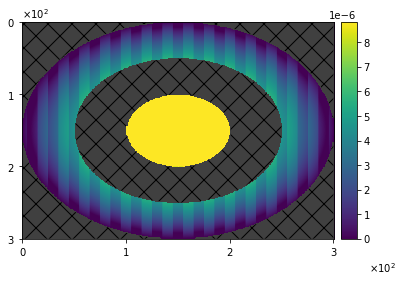

0.0 88.44


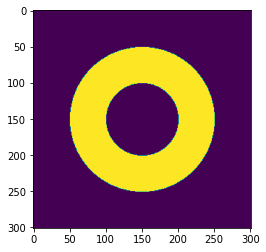

(88, 301, 301)


In [1]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils, plotting
from lens_simulation import Simulation
from pprint import pprint
from lens_simulation.Lens import Lens
from scipy import fftpack
from lens_simulation.structures import SimulationStage, SimulationParameters, SimulationOptions, SimulationResult
from tqdm import tqdm
import numpy as np
import zarr
import matplotlib.pyplot as plt
from lens_simulation import SimulationRunner

from lens_simulation.run_simulation import main
from lens_simulation.Lens import generate_lens, Lens
from lens_simulation.Medium import Medium
from lens_simulation import utils, plotting
import matplotlib.pyplot as plt
config = utils.load_config("config.yaml")

lens = generate_lens(config["lenses"][0], Medium(2.348), 1e-6)

plotting.plot_lens_profile_2D(lens)
plt.show()


def create_3d_lens(lens: Lens) -> np.ndarray:
    """Convert the 2D lens height map into 3D profile"""
    # ref: https://stackoverflow.com/questions/59851954/numpy-use-2d-array-as-heightmap-like-index-for-3d-array
    lens_profile = lens.profile * 10e6
    lens_profile = lens_profile * lens.aperture
    print(np.min(lens_profile), np.max(lens_profile))

    l_max = int(np.max(lens_profile))
    arr3d = np.ones(shape=(l_max, lens_profile.shape[0], lens_profile.shape[1]))

    for y in range(lens.profile.shape[0]):
        for x in range(lens.profile.shape[1]):
            height = int(lens_profile[y, x])
            arr3d[height:, y, x] = 0

    return arr3d

arr3d = create_3d_lens(lens)

plt.imshow(arr3d[0, :, :])
plt.show()


print(arr3d.shape)

In [2]:
import napari
from magicgui import magicgui
from napari.layers import Image
from napari.types import ImageData

# create a viewer and add some images
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(arr3d, name="lens", colormap="turbo", rendering="average", scale=[1, 1, 1], depiction="volume")

napari.run()

c:\Users\pcle0002\Miniconda3\envs\lens_sim\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


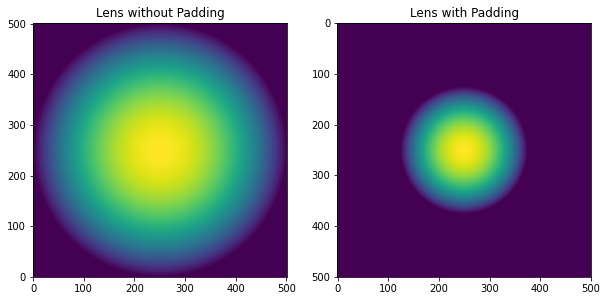

In [24]:

config = utils.load_config("example/sim_focus_2d.yaml")

lens = generate_lens(config["lenses"][0], Medium(2.348), 1e-6)

fig = plotting.plot_lens_profile_2D(lens, title="Lens with Padding")


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(lens.profile)
ax[0].set_title("Lens without Padding")

lens.profile = np.pad(lens.profile, (125, 125), mode="constant", constant_values=0)

ax[1].imshow(lens.profile)
ax[1].set_title("Lens with Padding")

plt.show()

